In [33]:
#importando pacotes essenciais

import numpy as np
import dateutil.parser as parse
import pandas as pd
import seaborn as sns
import matplotlib as mlp
import matplotlib.pyplot as plt
import csv
from datetime import *

#plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [34]:
#plotando o graficos dos dados originais

def plot_df(df, x, y, title="", xlabel='Data', ylabel="Valores", dpi=100):
    plt.figure(figsize=(8,4), dpi=dpi)
    plt.plot(x, y, color="tab:blue")
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
   

In [35]:
def convert(dt, tmp):
    date = datetime.strptime(dt, "%Y-%m-%d")
    
    return (
       datetime.strftime(date, "%Y-%m-%d"),
       float(tmp),
       datetime.timestamp(date),
       float(tmp),
       date.day,
       date.month,
       date.year, 
       )

In [36]:
def import_data():
    data = None
    with open('daily-minimum-temperatures.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        data = [convert(*row) for i, row in enumerate(csv_reader) if i > 0]
    return np.array(data)
    
 

In [37]:
def kfold(data, k=1, shuffle=True):
    k = k + 1
    folds = []
    if shuffle:
        permutation = np.random.permutation(data.shape[0])
        data = data[permutation, :]
        
    mb = np.ceil(data.shape[0] / k).astype(np.int32)
    for r, _ in enumerate(range(k)):
        ini, end = r * mb, mb * (r+1)
        folds.append(data[ini:end, :])
    return np.array(folds)
        

In [38]:
class Scaler:
    
    def __init__(self):
        self._mu = 0
        self._std = 0
        
    def fit(self, x):
        self._mu = np.mean(x)
        self._std = np.std(x)
        
    def transform(self, x):
        y = np.copy(x)
        return (y - self._mu) / self._std
    
    def inverse(self, x):
        y = np.copy(x)
        return (y * self._std) + self._mu
    
    def __repr__(self):
        return f"{self._mu}, {self._std}"
        

In [39]:
class Normalizer:
    
    def __init__(self):
        self._min = 0
        self._max = 0
        
    def fit(self, x):
        self._min = np.min(x)
        self._max = np.max(x)
        
    def transform(self, x):
        y = np.copy(x)
        return (y - self._min) / (self._max - self._min)
    
    def inverse(self, x):
        y = np.copy(x)
        return (y * (self._max - self._min)) + self._min
    
    def __repr__(self):
        return f"{self._min}, {self._max}"

In [40]:
class LinearRegressionImpl:

    def __init__(self, fit_intercept=True, reg=1e-20, weights=None):
        self.w = weights
        self.fit_intercept = fit_intercept
        self._reg = reg
        
    def mse(self, y, yh):
        N = y.shape[0]
        L2 = (self._reg / (2 * N)) * np.sum([np.sum(np.square(w)) for w in self.w])
        return ((1 / N) * np.sum(np.square(y - yh))) + L2
    
    def _correct_X(self, X):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        return X
    
    def train(self, X, y):
        X = self._correct_X(X)
        
        pinv = np.dot(X.T, X)
        reg = np.eye(pinv.shape[0], dtype=int) * self._reg
        reg[0][0] = 1
        nX = np.dot(np.linalg.inv(pinv + reg), X.T)
        self.w = np.dot(nX, y)
        
        yh = np.dot(X, self.w)
        J = self.mse(y, yh)
        return self, J
    
    def predict(self, X):
        X = self._correct_X(X)
        return np.dot(X, self.w)
    


In [41]:
class PolynomialRegressionImpl(LinearRegressionImpl):
    
    def __init__(self, fit_intercept=True, reg=1e-20, weights=None, degree=1):
        super().__init__(fit_intercept, reg, weights)
        self.degree = degree
        
    def _correct_X(self, X):
        M = np.copy(X)
        for degree in range(2, self.degree):
            M = np.c_[M, np.power(X, degree)]
        X = np.copy(M)
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        return X

In [42]:
data = import_data()
df_data = np.copy(data)
data = data[:, 2:].astype(np.float32)

dts = pd.DataFrame(df_data)
dts1990 = dts[dts[0].str.contains("1990")]
dts1990 = dts1990[dts1990[0].str.contains("(01\/)(01|02|03|04|05|06|07|08|09|10|11|12)", regex=True)]

dts = dts[dts[0].str.contains("01/01")]

df = pd.DataFrame(df_data[:, 0:2], columns=["Data", "Temperature"])
print(df)

            Data Temperature
0     1981-01-01        20.7
1     1981-01-02        17.9
2     1981-01-03        18.8
3     1981-01-04        14.6
4     1981-01-05        15.8
5     1981-01-06        15.8
6     1981-01-07        15.8
7     1981-01-08        17.4
8     1981-01-09        21.8
9     1981-01-10        20.0
10    1981-01-11        16.2
11    1981-01-12        13.3
12    1981-01-13        16.7
13    1981-01-14        21.5
14    1981-01-15        25.0
15    1981-01-16        20.7
16    1981-01-17        20.6
17    1981-01-18        24.8
18    1981-01-19        17.7
19    1981-01-20        15.5
20    1981-01-21        18.2
21    1981-01-22        12.1
22    1981-01-23        14.4
23    1981-01-24        16.0
24    1981-01-25        16.5
25    1981-01-26        18.7
26    1981-01-27        19.4
27    1981-01-28        17.2
28    1981-01-29        15.5
29    1981-01-30        15.1
...          ...         ...
3620  1990-12-02        13.2
3621  1990-12-03        16.2
3622  1990-12-

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


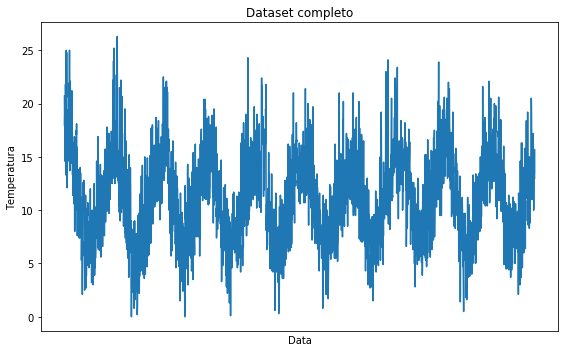

In [43]:
plt.figure(figsize=(8, 5))
plt.plot(data[:, 0], data[:, 1])
plt.title("Dataset completo")
plt.xticks(dts[2].to_numpy().astype(np.float32), dts[0].to_numpy(), rotation=90)
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.tight_layout()
plt.show()

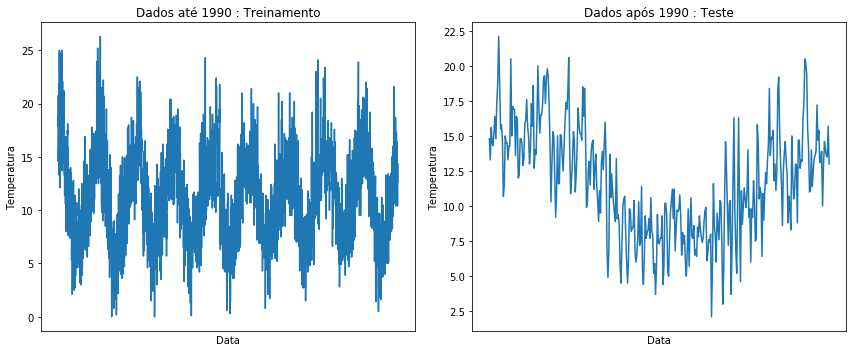

In [44]:
#dividindo o dataset
dt_1990 = datetime.timestamp(datetime.strptime("1990-01-01 00:00:00", "%Y-%m-%d %H:%M:%S"))

train, test = data[data[:, 0] < dt_1990], data[data[:, 0] >= dt_1990]

X_train, y_train = train[:, 2], train[:, 1]
X_test, y_test = test[:, 2:], test[:, 1]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train[:, 0], y_train)
plt.title("Dados até 1990 : Treinamento")
plt.xticks(dts[2].to_numpy().astype(np.float32), dts[0].to_numpy(), rotation=90)
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.subplot(1, 2, 2)
plt.plot(test[:, 0], y_test)
plt.title("Dados após 1990 : Teste")
plt.xticks(dts1990[2].to_numpy().astype(np.float32), dts1990[0].to_numpy(), rotation=90)
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.tight_layout()
plt.show()


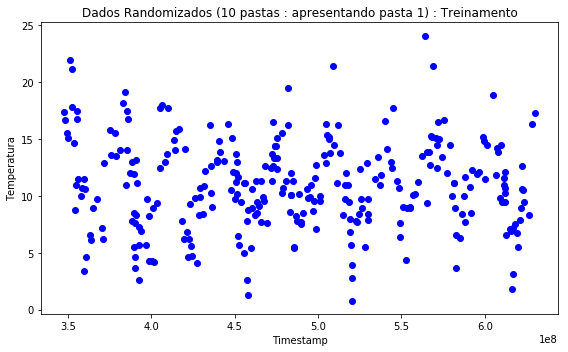

In [46]:
# randomizdos

folds = kfold(train, k=10, shuffle=True)

plt.figure(figsize=(8, 5))
plt.title("Dados Randomizados (10 pastas : apresentando pasta 1) : Treinamento")
plt.xlabel("Timestamp")
plt.ylabel("Temperatura")
plt.plot(folds[0][:, 0], folds[0][:, 1], 'bo')
plt.tight_layout()
plt.show()

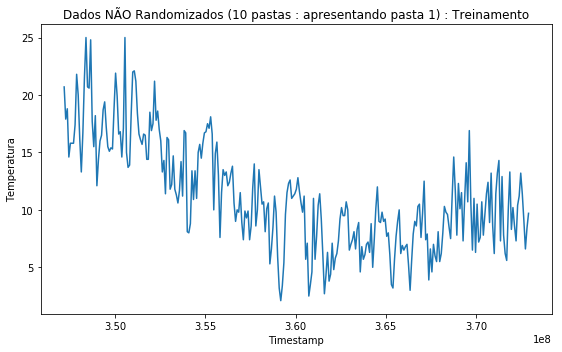

In [47]:
#nao randomizados

folds = kfold(train, k=10, shuffle=False)

plt.figure(figsize=(8, 5))
plt.title("Dados NÃO Randomizados (10 pastas : apresentando pasta 1) : Treinamento")
plt.xlabel("Timestamp")
plt.ylabel("Temperatura")
plt.plot(folds[0][:, 0], folds[0][:, 1])
plt.tight_layout()
plt.show()

#### **Exercício 1**

Calcular a melhor predição de acordo com os dados usando Quadrados Mínimos.

$w = \phi^T(\phi \phi^T)^{-1}y$

Usando K-Fold Cross Validation, o dataset foi dividido e executado para cada parâmetro de K. Sendo k a quantidade de atrasos.

Conforme discutido em aula, os atrasos da série, aqueles cujas valores começam a posição inicial poderiam ser preenchidos com 0 (zero). Entretanto, tentanto evitar um desvio inicial muito grande, essa série atrasada inicial foi preenchidas com valores de uma distribuição uniforme variando do valor mínimo e máximo contido dentro do dataset, conforme abaixo.

In [48]:
alld = data[:, 1]
nmin = np.round(np.min(alld).astype(np.float), 2)
nmax = np.round(np.max(alld).astype(np.float), 2)

print("Valores: ")
print(f"Minimo: {nmin}, Maximo {nmax}")

Valores: 
Minimo: 0.0, Maximo 26.3


Regressao linear, com  1 < k < 30 e k-fold ate 20

In [49]:
def sparse_temporal_data(data, nmin, nmax):
    dados = data[:, 1]
    size = len(dados)
    std = []
    
    for k in range (1, 32):
        x = []
        for i in range (size):
            r = 0 if i-k < 0 else i-k
            ds = dados[r:i]
            if len(ds) < k:
                before = np.round(np.random.uniform(nmin, nmax, size=(k-len(ds), )), 2)
                ds = np.concatenate((before, ds))
            x.append(np.concatenate((ds, np.array([i]))))
        std.append(x)
    return std

train_k = sparse_temporal_data(train, nmin, nmax)
test_k = sparse_temporal_data(test, nmin, nmax)

In [50]:
J_k = []
for k in range (1, 32):
    for kf in range(1, 20):
        folds = kfold(np.array(train_k[k-1]), k = kf, shuffle=False)
        J = []
        better_J = 1e+10
        kf_val = 0
        for i in range(0, kf):
            
            #set de validacao
            X_val, y_val = folds[i][:, :k], folds[i][:, k]
            
            #set de treino
            nF = np.append(folds[i+1:, ], folds[:i, ], axis=0)
            X, y = nF[0][:, :k], nF[0][:, k]
            
            #treino
            linreg, _ = LinearRegressionImpl().train(X, y)
            
            #predicoes
            yh = linreg.predict(X_val)
            
            #MSE
            e = linreg.mse(y_val, yh)
            J.append(e)
            
            if e < better_J:
                kf_val = i
                better_J = e
                
        J_k.append((k, kf, kf_val, np.mean(J), folds))
J_k = np.array(J_k)
            

In [51]:
best_result = None
best_J = 1e+10
for m in range (1, 32):
    c = J_k[(J_k[:, 0] == m)]
    mean = np.mean(c[:, 3])
    if best_J > mean:
        best_J = mean
        best_result = c[c[:, 3] == np.min(c[:, 3])][0]
            

Resultados: 
K: 1 - k-fold: 19 / 15


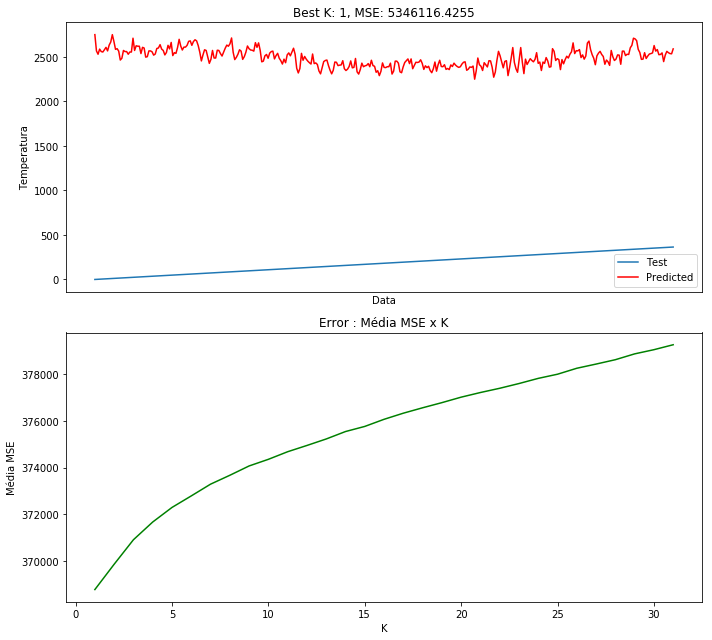

In [52]:
#Encontrar o melhor k e set de validacao

k, ft, i, mse, folds = best_result
k = int(k)

print("Resultados: ")
print(f"K: {k} - k-fold: {ft} /", i+1)

minor_J0 = 1e+10
best_weights = None

# Validation set
X_val, y_val = folds[i][:, :k], folds[i][:, k]

# Training set
nF = np.append(folds[i+1:, ], folds[:i, ], axis=0)
X, y = nF[0][:, :k], nF[0][:, k]

# Train
linreg, _ = LinearRegressionImpl().train(X, y)
best_weights = linreg.w

# Running again for the best result
lr = LinearRegressionImpl(weights=best_weights)
test_f = np.array(test_k[k-1])
X_test, y_test = test_f[:, :k], test_f[:, k]
yh_test = lr.predict(X_test)
mse = lr.mse(y_test, yh_test)

# Data table
df = pd.DataFrame([Jk[:4] for Jk in J_k], columns=["K", "K-Fold", "Validation Fold", "Média MSE"])
df["Validation Fold"] += 1

k_mse_mean = []
for m in range(1, 32):
    c = J_k[(J_k[:, 0] == m)]
    k_mse_mean.append(np.mean(c[:, 3]))

plt.figure(figsize=(10, 9))
plt.subplot(2, 1, 1)
plt.title(f"Best K: {k}, MSE: {np.round(mse, 4)}")
plt.xticks(dts1990[2].to_numpy().astype(np.float32), dts1990[0].to_numpy(), rotation=90)
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.plot(test[:, 0], y_test, label="Test")
plt.plot(test[:, 0], yh_test, 'r', label="Predicted")
plt.legend()
plt.subplot(2, 1, 2)
plt.title(f"Error : Média MSE x K")
plt.xlabel("K")
plt.ylabel("Média MSE")
plt.plot(np.arange(1, 32), k_mse_mean, "g")
plt.tight_layout()
plt.show()

Os gráficos acima, apresentam os valores após filtro pós-processamento para escolher o melhor valor de K.

Abaixo, são apresentados os primeiros 10 itens da iteração total executada. O primeiro item não representa a melhor opção, pois para escolha da melhor opção foi calculada a média dos valores.

In [54]:
df = df.sort_values(by=["Média MSE", "K"]).head(10)
# df.style.hide_index()
print(df)

     K  K-Fold  Validation Fold     Média MSE
18   1      19               15  29761.061867
37   2      19               13  31461.487658
56   3      19               13  33417.880346
17   1      18                8  34791.892876
75   4      19                4  35160.530095
94   5      19                4  36645.581833
36   2      18                8  36747.400913
113  6      19                4  37993.082489
55   3      18                8  39012.061429
132  7      19                4  39336.033953


É possível também, usar de outra alternativa no método de K-Fold... no caso estamos embaralhando os dados antes de passar para o método e consequentemente o modelo. Por fim, chegamos aproximadamente no mesmo resultado, entretanto tomando um caminho de certa maneira diferente... Neste sentido, podemos encontrar os melhores valores $W$ para o modelo em folds totalmente direfentes.

In [55]:
fold_N, fold_val = 0, 0
J_k = []
for k in range(1, 32):
    for kf in range(1, 20):
        folds = kfold(np.array(train_k[k-1]), k=kf, shuffle=True)
        J = []
        better_J = 1e+10
        val_fold = 0
        for i in range(kf):
            # Validation set
            X_val, y_val = folds[i][:, :k], folds[i][:, k]
            # Training set
            nF = np.append(folds[i+1:, ], folds[:i, ], axis=0)
            X, y = nF[0][:, :k], nF[0][:, k]
            # Train
            linreg, _ = LinearRegressionImpl().train(X, y)
            # Predict
            yh = linreg.predict(X_val)
            # MSE
            e = linreg.mse(y_val, yh)
            J.append(e)
            if e < better_J:
                val_fold = i
                better_J = e
        J_k.append((k, kf, val_fold, np.mean(J), folds))
J_k = np.array(J_k)


In [56]:
best_result = None
best_J = 1e+10
for m in range(1, 32):
    c = J_k[(J_k[:, 0] == m)]
    mean = np.mean(c[:, 3])
    if best_J > mean:
        best_J = mean
        best_result = c[c[:, 3] == np.min(c[:, 3])][0]

Melhores valores
--------------------
K     : 1
K-Fold: 1 / 1


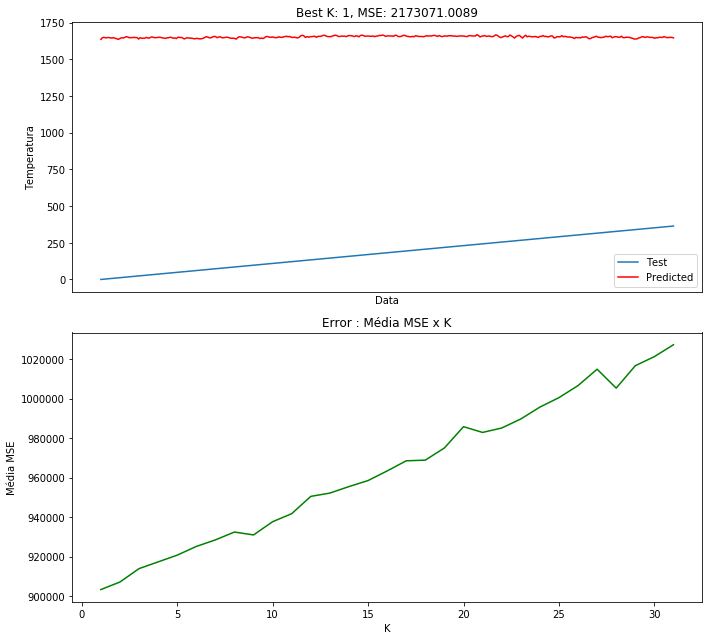

In [57]:
# Encontramos o melhor K e Validation Set.
k, kf, i, mse, folds = best_result
k = int(k)
print("Melhores valores")
print("-" * 20)
print("K     :", k)
print("K-Fold:", kf, "/", i+1)

minor_J0 = 1e+10
best_weights = None
# Validation set
X_val, y_val = folds[i][:, :k], folds[i][:, k]
# Training set
nF = np.append(folds[i+1:, ], folds[:i, ], axis=0)
X, y = nF[0][:, :k], nF[0][:, k]
# Train
linreg, _ = LinearRegressionImpl().train(X, y)
best_weights = linreg.w

# Running again for the best result
lr = LinearRegressionImpl(weights=best_weights)
test_f = np.array(test_k[k-1])
X_test, y_test = test_f[:, :k], test_f[:, k]
yh_test = lr.predict(X_test)
mse = lr.mse(y_test, yh_test)

# Data table
df = pd.DataFrame([Jk[:4] for Jk in J_k], columns=["K", "K-Fold", "Validation Fold", "Média MSE"])
df["Validation Fold"] += 1

k_mse_mean = []
for m in range(1, 32):
    c = J_k[(J_k[:, 0] == m)]
    k_mse_mean.append(np.mean(c[:, 3]))

plt.figure(figsize=(10, 9))
plt.subplot(2, 1, 1)
plt.title(f"Best K: {k}, MSE: {np.round(mse, 4)}")
plt.xticks(dts1990[2].to_numpy().astype(np.float32), dts1990[0].to_numpy(), rotation=90)
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.plot(test[:, 0], y_test, label="Test")
plt.plot(test[:, 0], yh_test, 'r', label="Predicted")
plt.legend()
plt.subplot(2, 1, 2)
plt.title(f"Error : Média MSE x K")
plt.xlabel("K")
plt.ylabel("Média MSE")
plt.plot(np.arange(1, 32), k_mse_mean, "g")
plt.tight_layout()
plt.show()

In [58]:
df = df.sort_values(by=["Média MSE", "K"]).head(10)
print(df)

      K  K-Fold  Validation Fold      Média MSE
78    5       3                1  884363.887690
25    2       7                7  887920.223265
0     1       1                1  889107.974436
172  10       2                2  891047.641823
133   8       1                1  892373.583303
228  13       1                1  893077.382346
22    2       4                2  893961.713991
209  12       1                1  894942.121463
229  13       2                1  895414.973926
399  22       1                1  895647.100634


#### **Exercício 2**

No exercício 2 usando o mesmo dataset usando anteriormente com a mesma questão de atraso, passaremos cada um dos itens por uma Rede Neural, usando como função de ativação a função hiperbólica.

Para validar a quantidade de unidades ( ou neurônios ) faremos a geração dessas unidades variando de 1 até 100 com seus pesos dentro de uma distribuição uniforme variando de -1 até 1.

Como valores para $\lambda$ (regularização) será utilizado o seguinte range: 1e+1 até 1e-6, dando espaçamentos de 0.1. Para visualmente ficar mais legível (devido a grande variação), os dados (os valores de regularização) são apresentados em escala logarítimica.

Para a normalização dos dados, evitando a saturação da tangente hiperbólica, os dados serão normalizados entre os valores de mínimo e máximo dos dados (os quais já foram apresentados acima).

Valores de K, estão dentro da faixa de 5 até 20 e o K-Fold utilizado foi de 1 até 10 folds.

In [32]:
all_data = np.concatenate((np.copy(train[:, 1]), np.copy(test[:, 1])))

scaler = Scaler()
scaler.fit(all_data)

normalizer = Normalizer()
normalizer.fit(all_data)

N_k = 10
N_T = 101

reg = np.array([
    1e+1, 1e+0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6
])
N_R = len(reg)

print(f"Valores de regularização testados: {len(reg)}")
print(reg)

Valores de regularização testados: 8
[1.e+01 1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06]


Neste exercício, vamos trabalhar com a série de temperatura mínima diária referente à
cidade de Melbourne, Austrália, no período de 1981 a 1990. As observações estão em
graus Celsius e há 3650 amostras no total. Os dados são creditados ao Australian
Bureau of Meteorology. 

In [40]:
#lendo os dados do arquivo csv com o pandas
dataset = pd.read_csv('daily-minimum-temperatures.csv', parse_dates=['Date'], index_col='Date')

In [41]:
#mostrando os ultimos registros
dataset.tail(5)

,Temp
Date,
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


In [35]:
#mostrando os primeiros registros
dataset.shape


(3650, 1)

In [29]:
#cria um array numpy com o mesmo shape do pandas
dados = np.ndarray(dataset.shape)
type(dados)

numpy.ndarray

In [6]:
#converte os dados em pandas para numpy
dados = dataset.values
dados.shape

(3650, 2)

In [7]:
#coluna 1
dados[:,[0]]

array([['1981-01-01'],
       ['1981-01-02'],
       ['1981-01-03'],
       ...,
       ['1990-12-29'],
       ['1990-12-30'],
       ['1990-12-31']], dtype=object)

In [8]:
#coluna 2
dados[:,[1]]

array([[20.7],
       [17.9],
       [18.8],
       ...,
       [13.5],
       [15.7],
       [13.0]], dtype=object)

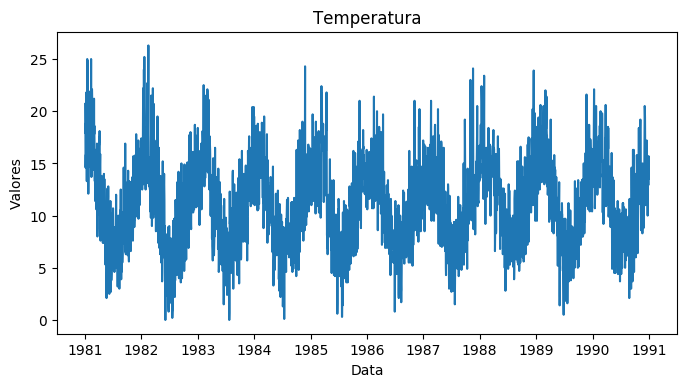

In [55]:
plot_df(dataset, x=dataset.index, y=dataset.values, title='Temperatura')

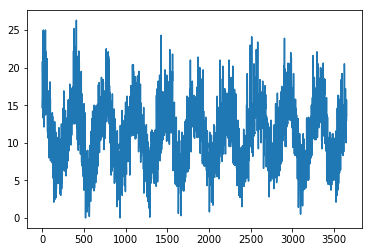

<Figure size 2880x720 with 0 Axes>

In [9]:
#grafico dos dados
plt.plot(dados[:,[1]])
plt.figure(figsize=(40, 10))
plt.show()

In [10]:
#dados sobre a temperatuda
np.mean(dados[:,[1]])

11.177753424657539

In [11]:
#dividindo o dataset em treino e teste
#dataset de testes sera o ultimo ano, 1990
#separando os ultimos 365 dados

In [12]:
dados.shape

(3650, 2)

In [13]:
#total das linhas subtraindo as ultimas 365 linhas do conjunto de testes
3650 - 365

3285

In [14]:
#novo array que recebe as ultimas 365 linhas
dados_teste = dados[3285:]

In [15]:
dados_teste.shape

(365, 2)

In [16]:
#removendo as ultimas 365 linhas do array de treino
dados = dados[:-365, :]

In [17]:
dados.shape, dados_teste.shape

((3285, 2), (365, 2))

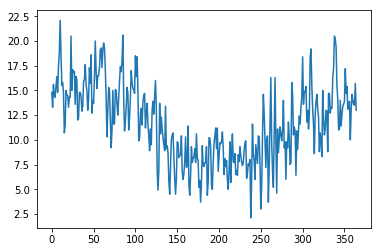

In [18]:
plt.plot(dados_teste[:,[1]])
plt.show()

In [19]:
#medias das temps da base de treino e de teste
np.mean(dados[:,[1]]), np.mean(dados_teste[:,[1]])

(11.123105022831052, 11.669589041095895)

In [ ]:
#function to determine or estimate the coefficients where x and y values are passed into this function

def estimate_coefficients(x ,y ):
    #pega o tamanho da base de dados
    n = np.size(x)
    
    #medias de x e y
    mean_x, mean_y = np.mean(x), np.mean(y)

    #calculando cross-deviation e deviation about x
    SS_xy = np.sum(y*x - n*mean_y*mean_x)
    SS_xx = np.sum(x*x - n*mean_x*mean_x)
    
    #calculando o coeficientes da regressao
    b_1 = SS_xy / SS_xx
    b_0 = mean_y - b_1*mean_x 
    
    return (b_0, b_1)
    

In [ ]:
#function to plot the graph based on calculated values.

def plot_regression_line(x, y, b):
    #plotando os pontos no grafico
    plt.scatter(x, y, color="red", marker="o", s=30)
    
    #vetor de predicao
    y_pred = b[0] + b[1]*x
    
    #plotando a linha de regressao
    plt.plot(x, y_pred, color="g")
    
    #legendas do grafico
    plt.xlabel('precos')
    plt.ylabel('periodo')
    plt.show()

In [16]:
#validacao cruzada
#Além disso, utilize um esquema de validação cruzada do tipo
#k-fold para selecionar o melhor valor do hiperparâmetro





' \nvalidacao cruzada\nAlém disso, utilize um esquema de validação cruzada do tipo\nk-fold para selecionar o melhor valor do hiperparâmetro\n'